In [9]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

# make a Location object corresponding to this TMY
location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

0.10.1


C:\Users\quean\anaconda3\lib\site-packages\pvlib\iotools\tmy.py:247: pvlibDeprecationWarning: TMY3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


In [10]:
print("We are looking at data from ", metadata['Name'], ",", metadata['State'])

We are looking at data from  "GREENSBORO PIEDMONT TRIAD INT" , NC


In [11]:
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
1990-01-01 01:00:00-05:00,166.841893,166.841893,-76.841893,-76.841893,6.889661,-3.395097
1990-01-01 02:00:00-05:00,160.512529,160.512529,-70.512529,-70.512529,52.424214,-3.414863
1990-01-01 03:00:00-05:00,149.674856,149.674856,-59.674856,-59.674856,73.251821,-3.434619
1990-01-01 04:00:00-05:00,137.777090,137.777090,-47.777090,-47.777090,85.208599,-3.454365
1990-01-01 05:00:00-05:00,125.672180,125.672180,-35.672180,-35.672180,94.134730,-3.474102


In [12]:
df_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=20,  # tilted 20 degrees from horizontal
    surface_azimuth=180,  # facing South
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic')

In [13]:
df_poa.keys()

Index(['poa_global', 'poa_direct', 'poa_diffuse', 'poa_sky_diffuse',
       'poa_ground_diffuse'],
      dtype='object')

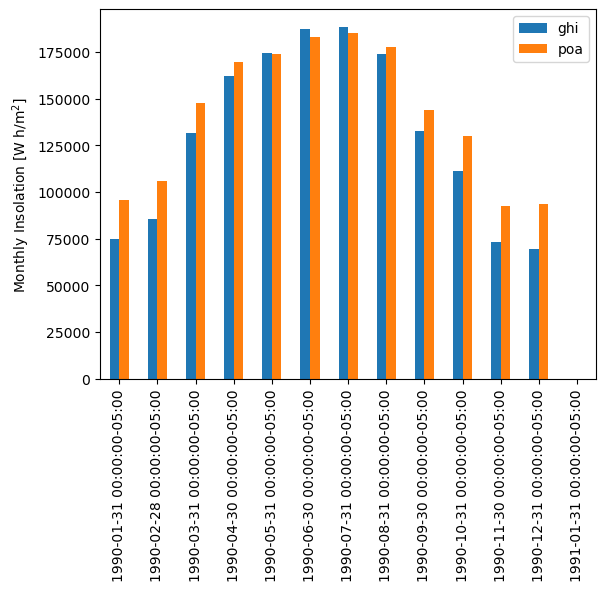

In [14]:
df = pd.DataFrame({
    'ghi': df_tmy['GHI'],
    'poa': df_poa['poa_global'],
})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar()
plt.ylabel('Monthly Insolation [W h/m$^2$]');

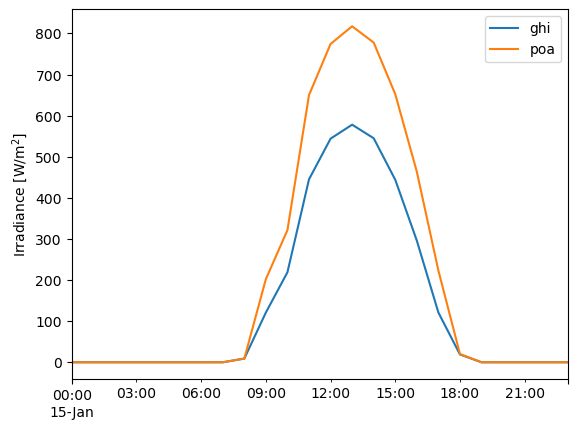

In [15]:
df.loc['1990-01-15'].plot()
plt.ylabel('Irradiance [W/m$^2$]');

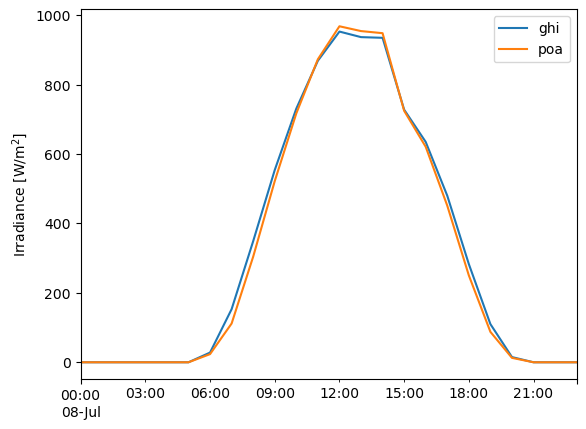

In [16]:
df.loc['1990-07-08'].plot()
plt.ylabel('Irradiance [W/m$^2$]');

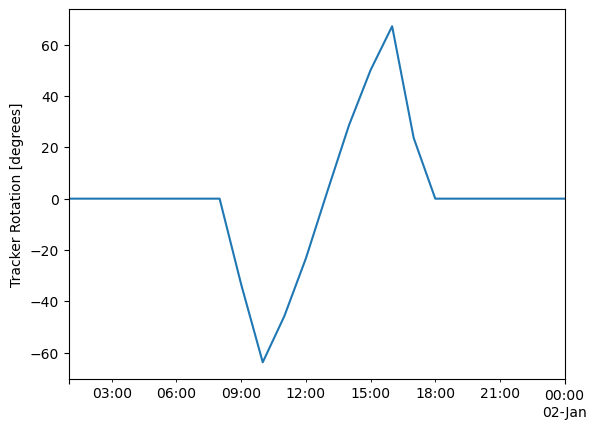

In [17]:
tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    axis_azimuth=180,  # axis is aligned N-S
    )  # leave the rest of the singleaxis parameters like backtrack and gcr at their defaults
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

# plot a day to illustrate:
tracker_data['tracker_theta'].fillna(0).head(24).plot()
plt.ylabel('Tracker Rotation [degrees]');

In [18]:
df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,  # time series for tracking array
    surface_azimuth=azimuth,  # time series for tracking array
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

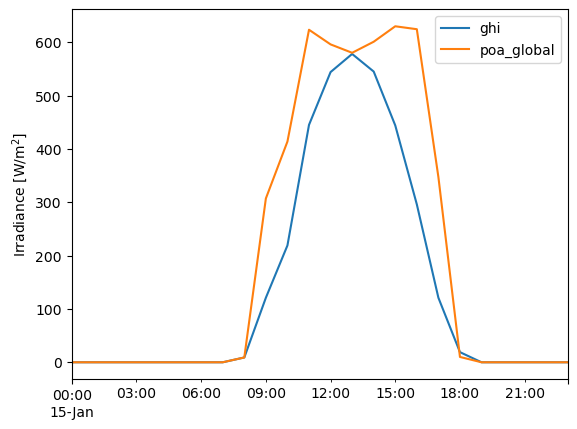

In [19]:
df.loc['1990-01-15', 'ghi'].plot()
tracker_poa.loc['1990-01-15'].plot()
plt.legend()
plt.ylabel('Irradiance [W/m$^2$]');